In [310]:
from selenium import webdriver
from bs4 import BeautifulSoup as soups

def search_selenium(search_name, search_path, search_limit):
    search_url = "https://www.google.com/search?q=" + str(search_name) + "&hl=ko&tbm=isch"

    browser = webdriver.Chrome('C:\chromedriver_win32\chromedriver.exe')
    browser.get(search_url)

    image_count = len(browser.find_elements_by_tag_name("img"))

    print("로드된 이미지 개수 : ", image_count)

    browser.implicitly_wait(2)

    for i in range(search_limit):
        image = browser.find_elements_by_tag_name("img")[i]
        image.screenshot("C:\pythonjupyter\camera\img" + str(i) + ".jpg")

    browser.close()
    
if __name__ == "__main__":
    search_name = input("검색하고 싶은 키워드 : ")
    search_limit = int(input("원하는 이미지 수집 개수 : "))
    search_path = "Your Path"
    # search_maybe(search_name, search_limit, search_path)
    search_selenium(search_name, search_path, search_limit)

검색하고 싶은 키워드 : 아이돌 전신 사진
원하는 이미지 수집 개수 : 150
로드된 이미지 개수 :  54


In [340]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "C:/Users/82106/.jupyter/CNN"
categories = ["lie", "stand","sit"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'C:/Users/82106/.jupyter/CNN',
        target_size=(64, 64),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'C:/Users/82106/.jupyter/CNN/test_person',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("C:/Users/82106/.jupyter/CNN/multi_image_data.npy", xy)

print("ok", len(y))

lie  파일 길이 :  300
lie  :  C:/Users/82106/.jupyter/CNN/lie\img0 (2).jpg
stand  파일 길이 :  300
stand  :  C:/Users/82106/.jupyter/CNN/stand\img0 (2).jpg
sit  파일 길이 :  300
sit  :  C:/Users/82106/.jupyter/CNN/sit\img0 (2).jpg
Found 1150 images belonging to 11 classes.
Found 0 images belonging to 0 classes.
ok 900


In [341]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
from keras import optimizers

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('C:/Users/82106/.jupyter/CNN/multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(675, 64, 64, 3)
675


In [342]:
categories = ["lie", "stand","sit"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [343]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu')) # 256
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
      
# model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    

In [344]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 16384)           

In [345]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test),
                    callbacks=[checkpoint, early_stopping])

Train on 675 samples, validate on 225 samples
Epoch 1/50
675/675 [==============================] - 25s 37ms/step - loss: 1.6272 - accuracy: 0.3156 - val_loss: 1.0947 - val_accuracy: 0.5467

Epoch 00001: val_loss improved from inf to 1.09468, saving model to ./model/multi_img_classification.model
Epoch 2/50
675/675 [==============================] - 16s 23ms/step - loss: 1.0746 - accuracy: 0.4459 - val_loss: 1.0482 - val_accuracy: 0.6178

Epoch 00002: val_loss improved from 1.09468 to 1.04819, saving model to ./model/multi_img_classification.model
Epoch 3/50
675/675 [==============================] - 16s 24ms/step - loss: 0.9978 - accuracy: 0.5304 - val_loss: 0.9005 - val_accuracy: 0.6356

Epoch 00003: val_loss improved from 1.04819 to 0.90046, saving model to ./model/multi_img_classification.model
Epoch 4/50
675/675 [==============================] - 16s 24ms/step - loss: 0.8365 - accuracy: 0.6474 - val_loss: 0.8005 - val_accuracy: 0.6444

Epoch 00004: val_loss improved from 0.90046 t

In [346]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

225/225 [==============================] - 1s 6ms/step
정확도 : 0.7378


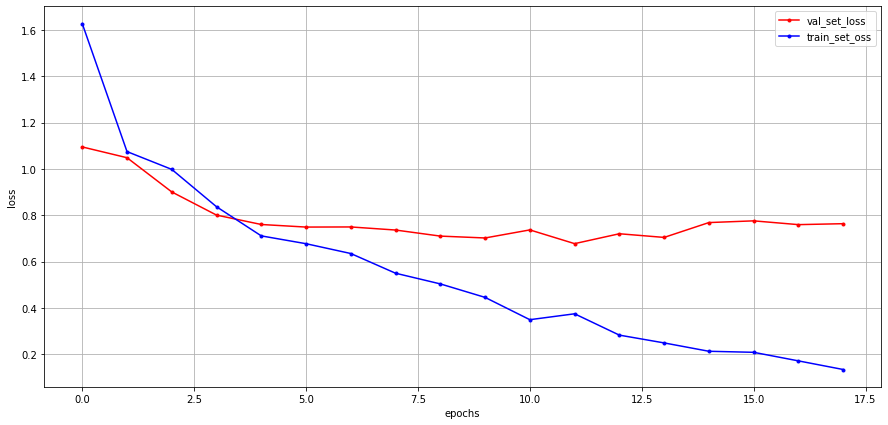

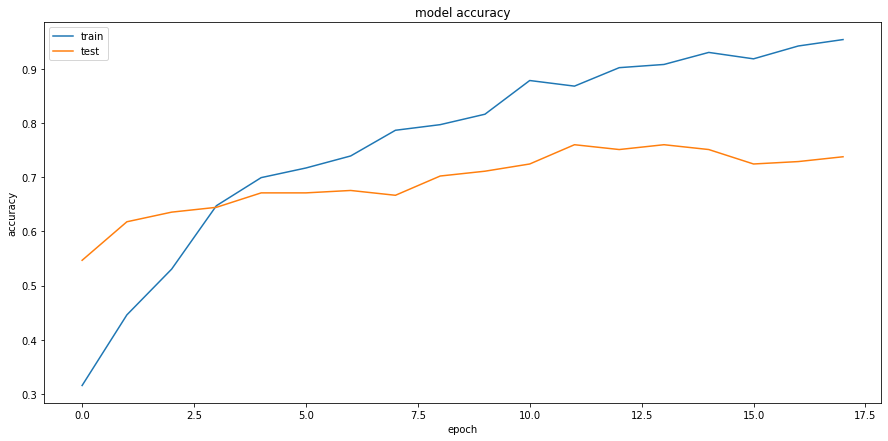

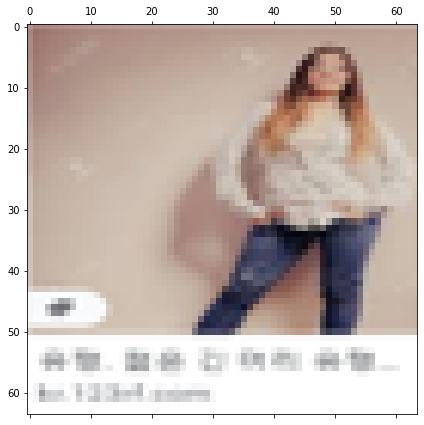

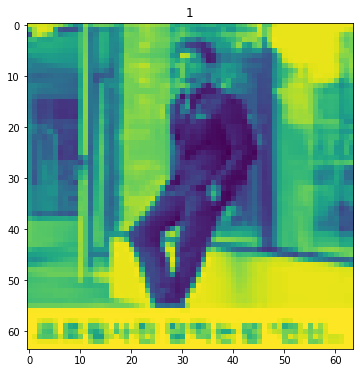

In [347]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.matshow(X_train[0, :, :], cmap='viridis')

plt.figure(figsize=(6,6))
plt.imshow(X_train[1][:,:,0])
plt.title(y_train[1].argmax());

In [348]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "C:/Users/82106/.jupyter/CNN/test_person"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "lie"
    elif pre_ans == 1: pre_ans_str = "stand"
    else: pre_ans_str = "sit"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


[0.000 1.000 0.000]
1
해당 lie1.jpg이미지는 stand으로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie10.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie2.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie3.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie4.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie5.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie6.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie7.jpg이미지는 lie로 추정됩니다.
[0.000 0.000 1.000]
2
해당 lie8.jpg이미지는 sit로 추정됩니다.
[1.000 0.000 0.000]
0
해당 lie9.jpg이미지는 lie로 추정됩니다.
[1.000 0.000 0.000]
0
해당 sit1.jpg이미지는 lie로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit10.jpg이미지는 stand으로 추정됩니다.
[0.000 0.000 1.000]
2
해당 sit2.jpg이미지는 sit로 추정됩니다.
[0.000 0.000 1.000]
2
해당 sit3.jpg이미지는 sit로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit4.jpg이미지는 stand으로 추정됩니다.
[1.000 0.000 0.000]
0
해당 sit5.jpg이미지는 lie로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit6.jpg이미지는 stand으로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit7.jpg이미지는 stand으로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit8.jpg이미지는 stand으로 추정됩니다.
[0.000 1.000 0.000]
1
해당 sit9.

In [349]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1, 64, 64, 3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

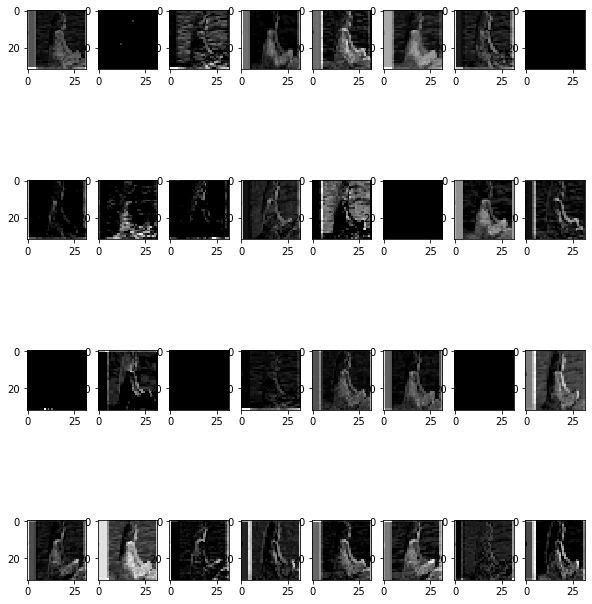

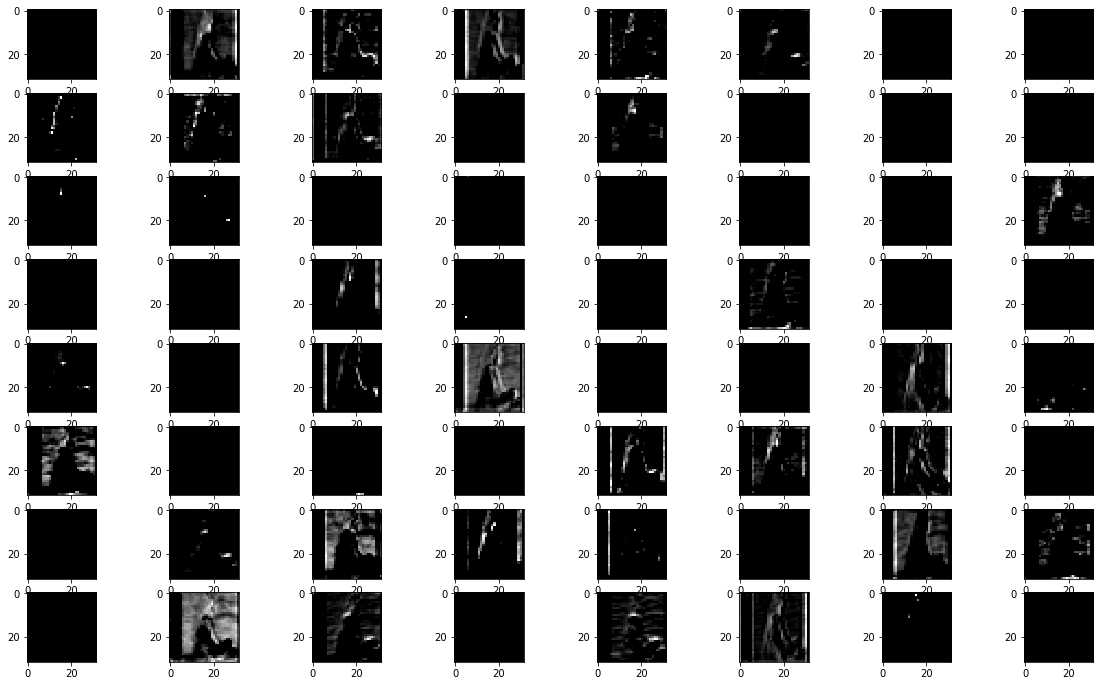

In [350]:
display_activation(activations, 8, 4, 1)
display_activation(activations, 8, 8, 3)

In [351]:
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(X_test)
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

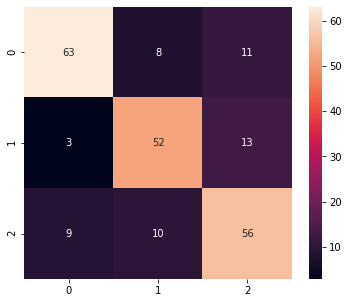

In [352]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

C:\Users\82106\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


MemoryError: Unable to allocate 32.0 TiB for an array with shape (8388608, 524288) and data type float64

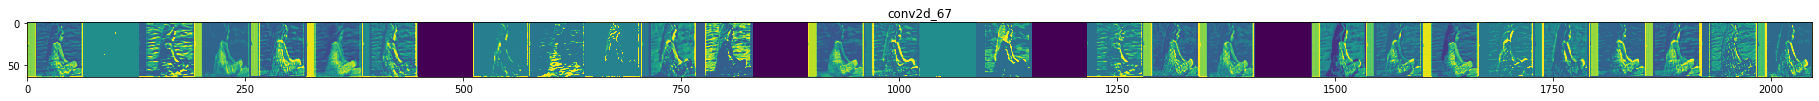

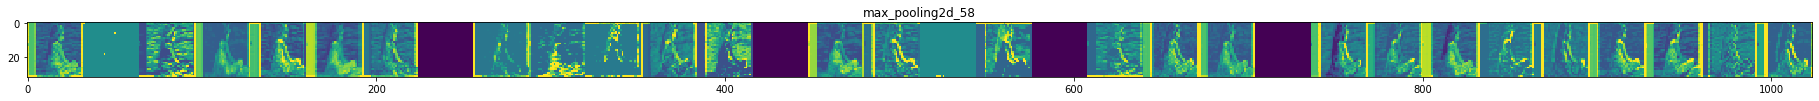

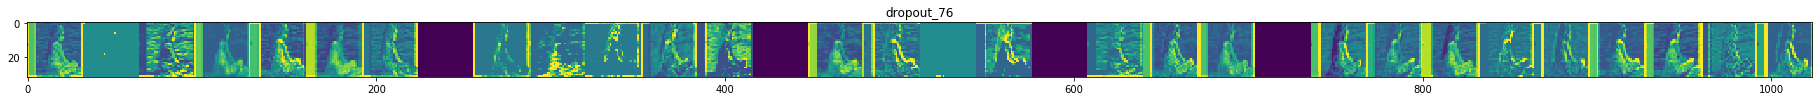

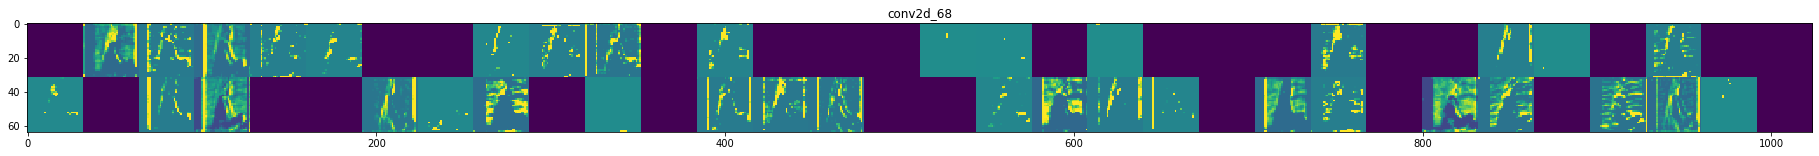

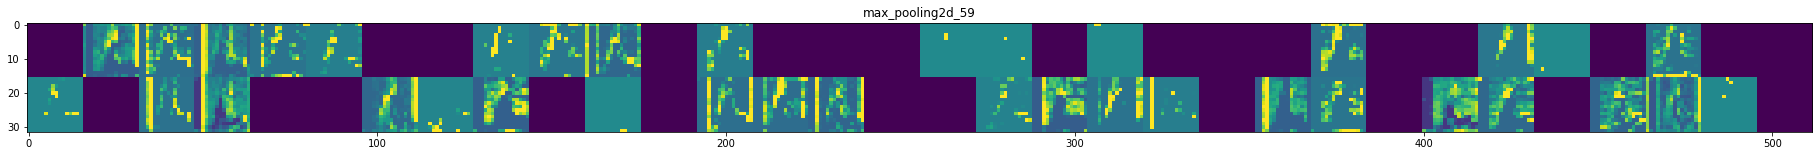

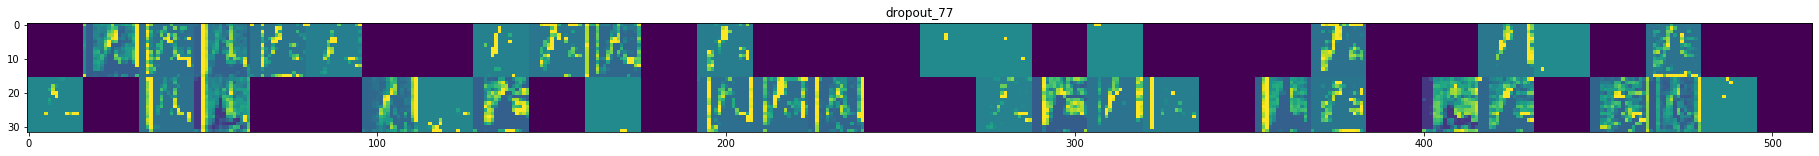

In [353]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 32

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

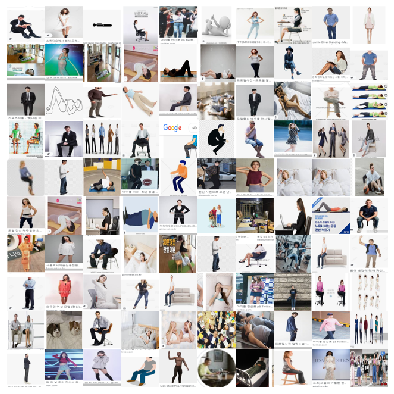

In [354]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
matplotlib.rc('font', family='NanumGothic')  # Linumx
  # matplotlib.rc('font', family='AppleGothic')  # Mac
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
    plt.imshow(im)
    plt.show()
      
figsize(15, 7)
display_cifar(X_train, 10)


In [355]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [356]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = 'C:/Users/82106/.jupyter/CNN/test_person/lie3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x= image.img_to_array(img)
x=np.expand_dims(x, axis=0)
x=preprocess_input(x)

In [357]:
preds = model.predict(x)
print('Predicted : ', decode_predictions(preds, top=3)[0])

Predicted :  [('n04209133', 'shower_cap', 0.26600283), ('n03188531', 'diaper', 0.20021449), ('n01910747', 'jellyfish', 0.06566117)]


In [358]:
np.argmax(preds[0])

793

In [359]:
african_elepant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')
grads= K.gradients(african_elepant_output, last_conv_layer.output)[0]
pooled_grads= K.mean(grads, axis=(0,1,2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *=pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis = -1)


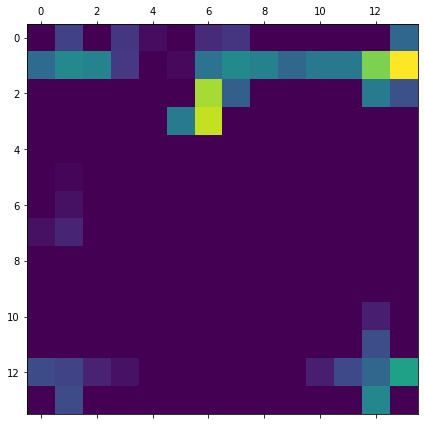

In [360]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)


In [337]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 +img
cv2.imwrite('C:/Users/82106/.jupyter/CNN/test_person/lie3.jpg', superimposed_img)


True